In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import seaborn as sns
import re
from ete3 import Tree
from collections import Counter
import os

In [2]:
gpa = pd.read_csv("/home/mliva/salmonella-pangenome-SP/03-results/03.1-panaroo/gene_presence_absence.csv")
genome_columns = gpa.columns[3:]

In [3]:
pa_matrix = gpa[genome_columns].notna().astype(int) 
pa_matrix.index = gpa["Gene"]


In [4]:
core_genes = pa_matrix.sum(axis=1) == pa_matrix.shape[1]
pa_core = pa_matrix[core_genes]

In [5]:
acc_genes = (pa_matrix.sum(axis=1) >= 2) & (pa_matrix.sum(axis=1) < pa_matrix.shape[1])
pa_acc = pa_matrix[acc_genes]


In [6]:
tree = Tree("/home/mliva/salmonella-pangenome-SP/03-results/03.2-iqtree/03.2.1.newick_tree/salmonella_core.treefile", format=1)

In [7]:
genome_order = [leaf.name for leaf in tree.iter_leaves()]

In [8]:
genomes = pa_matrix.columns.tolist()

provinces = ["Quebec", "Ontario", "Alberta", "New_Brunswick", "British_Columbia", "Nova_Scotia" ]


In [9]:
meta = pd.DataFrame({
    "genome": genomes
})

def extract_province(name):
    for p in provinces:
        if name.startswith(p):
            return p
    return "Unknown"

meta["province"] = meta["genome"].apply(extract_province)

In [10]:
province_series = meta.set_index("genome").loc[genome_order, "province"]


In [27]:
province_colors = {
    "Quebec": "#F7083E",
    "Ontario": "#550EF1",
    "Alberta": "#AAF10E",
    "New_Brunswick": "#08F7C1",
    "British_Columbia": "#004A94",
    "Nova_Scotia": "#F6E609"
}
col_colors = province_series.map(province_colors)

In [12]:
gene_data = pd.read_csv("/home/mliva/salmonella-pangenome-SP/03-results/panaroo_out/gene_data.csv")
gene_data_idx = gene_data.set_index("annotation_id")


In [13]:
def parse_ids(cell):
    """
    Extracts potential IDs from a GPA cell.
    Supports common separators (;) and spaces.
    """
    if pd.isna(cell):
        return []
    s = str(cell).strip()
    if s == "" or s == "0":
        return []
    parts = re.split(r"[;,\s]+", s)
    return [p for p in parts if p]

In [14]:
def representative_protein_for_gene(row):
    """
    For a gene in the pangenome (GPA row),
    find the first annotation_id present in any genome,
    and retrieve its prot_sequence from gene_data.
    """
    for col in genome_columns:
        ids = parse_ids(row[col])
        for ann_id in ids:
            if ann_id in gene_data_idx.index:
                seq = gene_data_idx.loc[ann_id, "prot_sequence"]
                return ann_id, seq
    return None, None


In [15]:
def most_frequent_description_for_gene(row):
    """
    For a gene in the pangenome (GPA row),
    collects all functional descriptions
    associated with the annotation_ids present in the genomes
    and returns the most frequent description.
    """
    descriptions = []

    for col in genome_columns:
        ids = parse_ids(row[col])
        for ann_id in ids:
            if ann_id in gene_data_idx.index:
                desc = gene_data_idx.loc[ann_id, "description"]
                if pd.notna(desc) and desc.strip() != "":
                    descriptions.append(desc)

    if not descriptions:
        return None

    return Counter(descriptions).most_common(1)[0][0]

In [17]:
group_to_description = {}

for _, row in gpa.iterrows():
    group = row["Gene"]

    desc = most_frequent_description_for_gene(row)

    if desc is not None:
        group_to_description[group] = desc
    else:
        group_to_description[group] = group

In [18]:
desc_series = pd.Series(group_to_description)

# filter hypothetical proteins
non_hypothetical = ~desc_series.str.contains(
    "hypothetical protein",
    case=False,
    na=False
)

In [19]:
desc_acc = desc_series.loc[pa_acc.index]
 
non_hypothetical_acc = ~desc_acc.str.contains(
    "hypothetical protein",
    case=False,
    na=False
)

pa_acc_filtered = pa_acc.loc[non_hypothetical_acc]


In [20]:
pa_acc_named = pa_acc_filtered.copy()
pa_acc_named.index = pa_acc_named.index.map(
    lambda g: group_to_description.get(g, g)
)


In [21]:
pct_removed = 100 * (1 - pa_acc_filtered.shape[0] / pa_acc.shape[0])
print(f"{pct_removed:.1f}% of accessory genes were hypothetical proteins")

69.6% of accessory genes were hypothetical proteins


In [22]:
out_dir = "/home/mliva/salmonella-pangenome-SP/03-results/04.4-heatmap_gen_presence_absence"

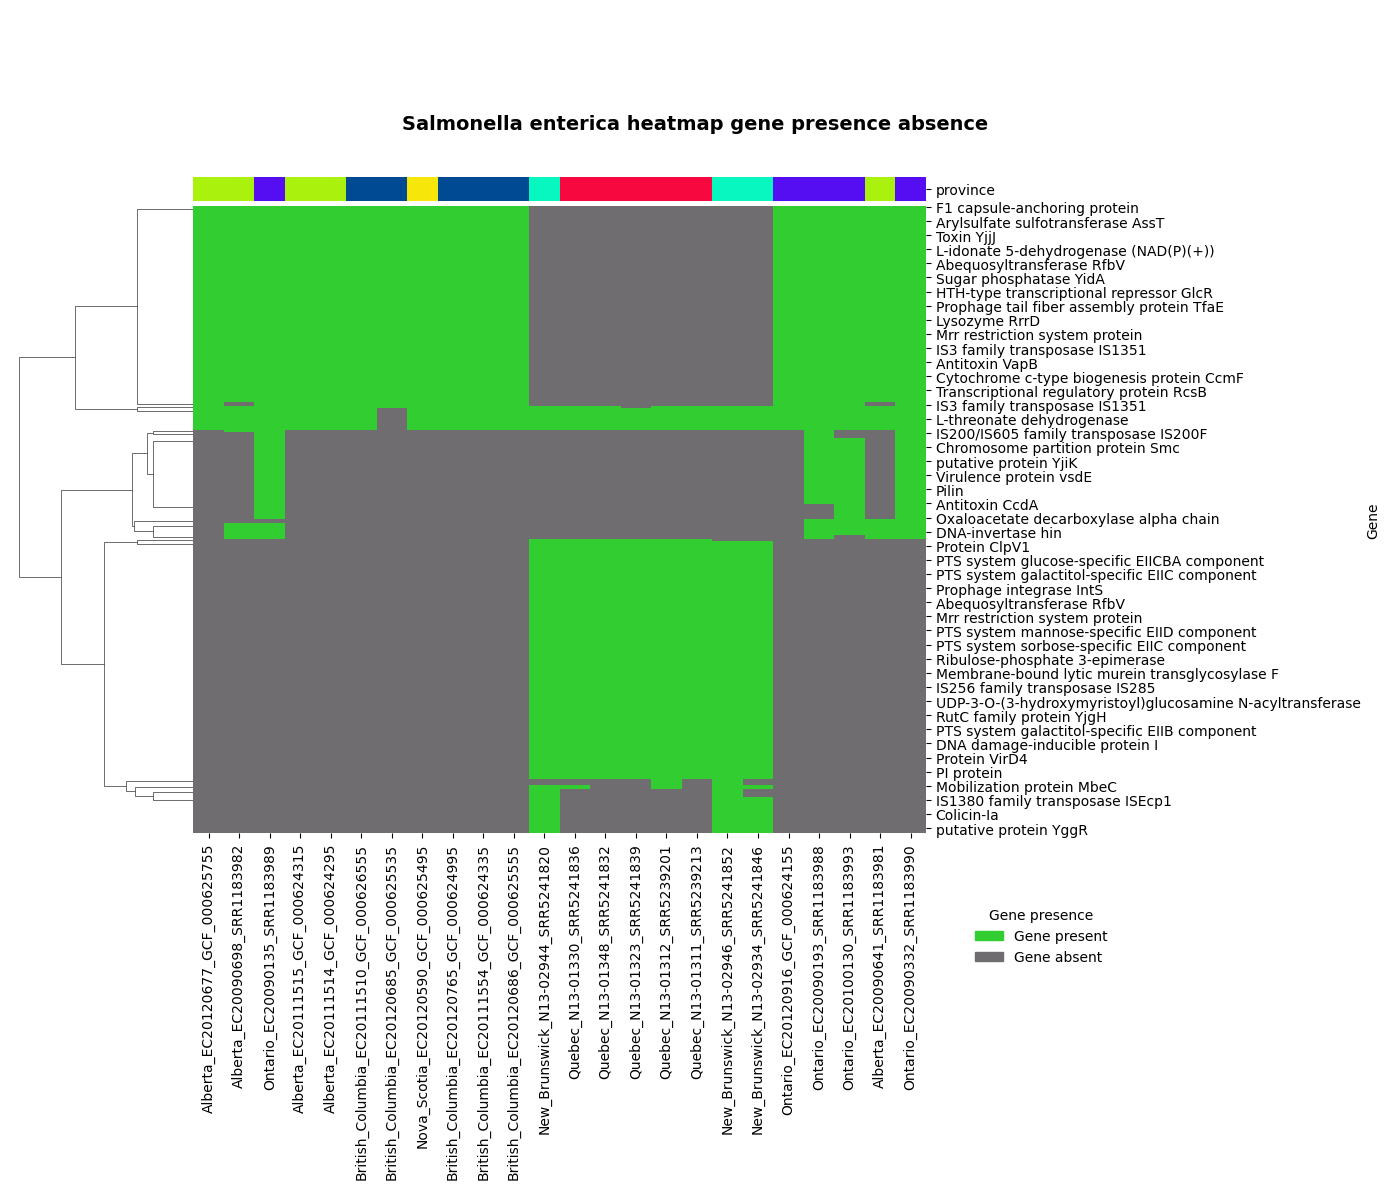

In [38]:
binary_cmap = ListedColormap([
    "#6F6D70",  # brown = absence
    "#32CD30"   # green = presence
])

g = sns.clustermap(
    pa_acc_named[genome_order],
    row_cluster=True,
    col_cluster=False,
    col_colors=col_colors,
    cmap=binary_cmap,
    figsize=(14, 12),
    cbar_pos=None,
)

legend_elements = [
    mpatches.Patch(color="#32CD30", label="Gene present"),
    mpatches.Patch(color="#6F6D70", label="Gene absent"),
]

g.ax_heatmap.legend(
    handles=legend_elements,
    title="Gene presence",
    loc="upper left",
    bbox_to_anchor=(1.05, -0.1),
    frameon=False
)

plt.suptitle(
    "Salmonella enterica heatmap gene presence absence",
    y=0.90,
    fontsize=14,
    fontweight="bold"
)

plt.savefig(f"{out_dir}/heatmap_description.png", dpi=300, bbox_inches="tight")
plt.show()


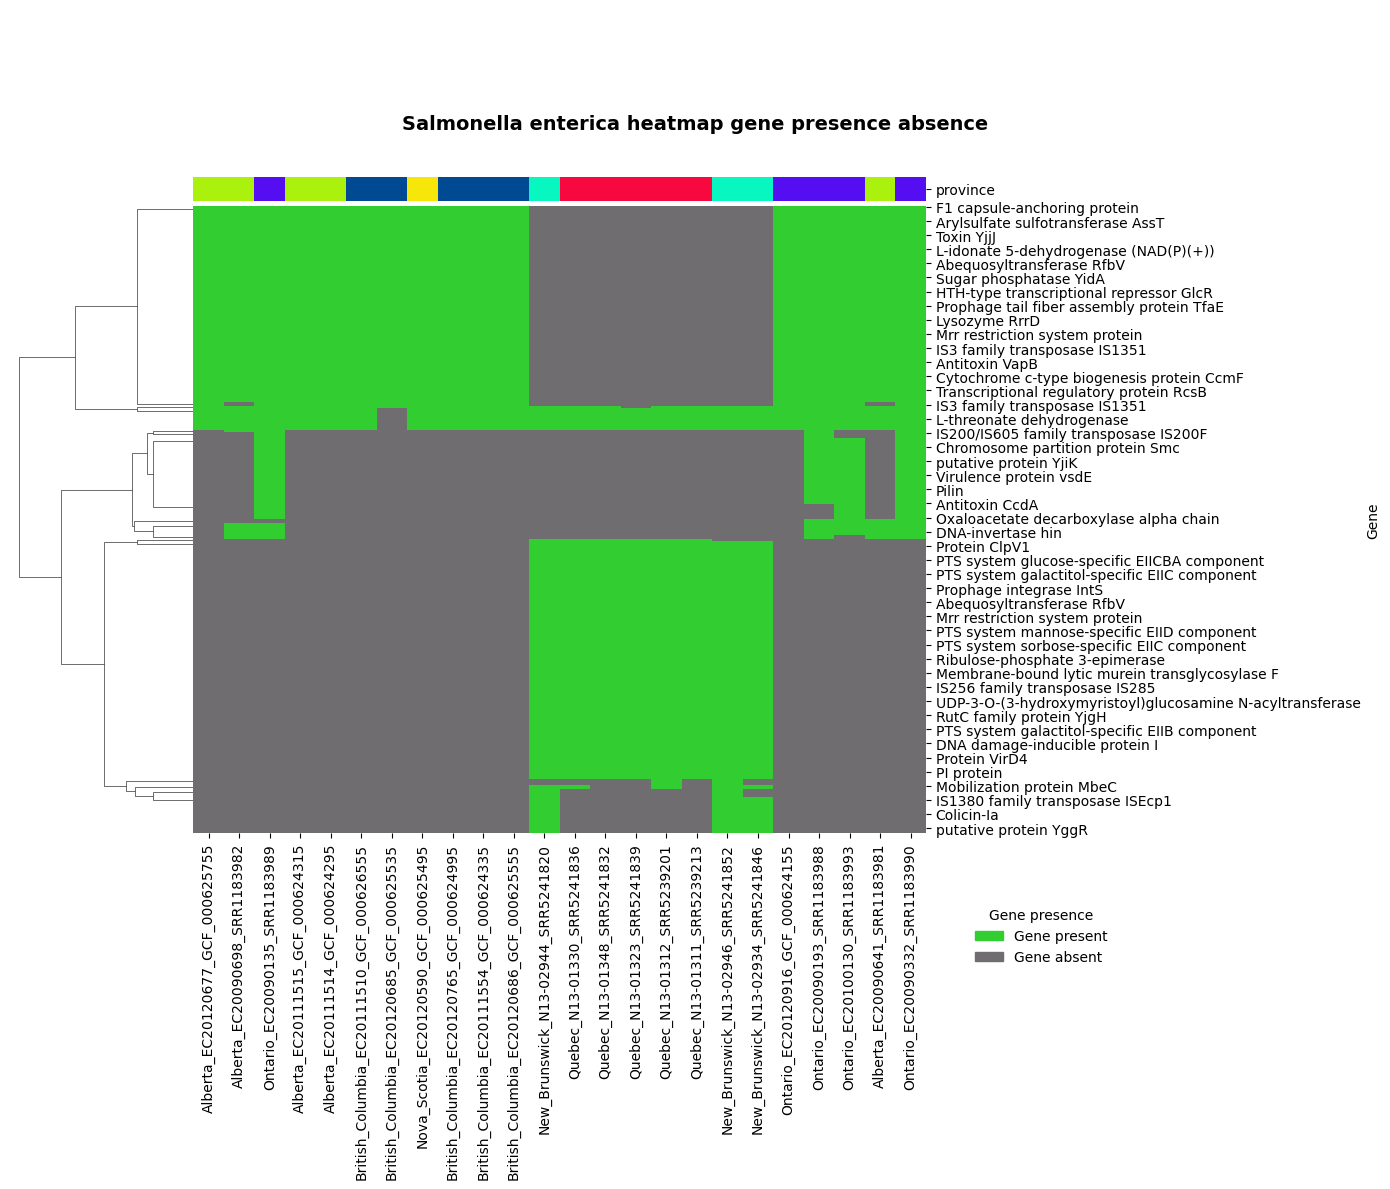

In [39]:
binary_cmap = ListedColormap([
    "#6F6D70",  # absence
    "#32CD30"   # presence
])

g = sns.clustermap(
    pa_acc_named[genome_order],
    row_cluster=True,
    col_cluster=False,
    col_colors=col_colors,
    cmap=binary_cmap,
    figsize=(14, 12),
    cbar_pos=None,
)

# Make background transparent
g.fig.patch.set_alpha(0)
for ax in g.fig.axes:
    ax.set_facecolor("none")

legend_elements = [
    mpatches.Patch(color="#32CD30", label="Gene present"),
    mpatches.Patch(color="#6F6D70", label="Gene absent"),
]

g.ax_heatmap.legend(
    handles=legend_elements,
    title="Gene presence",
    loc="upper left",
    bbox_to_anchor=(1.05, -0.1),
    frameon=False
)

plt.suptitle(
    "Salmonella enterica heatmap gene presence absence",
    y=0.90,
    fontsize=14,
    fontweight="bold"
)

plt.savefig(
    f"{out_dir}/heatmap_description_transparent.png",
    dpi=300,
    bbox_inches="tight",
    transparent=True
)

plt.show()
